### Project4_Camera calibration and epipolar geometry
LiWang 18461271

## 1.(a)How to determine the camera matrix P

First of all, we choose corners on the image, by using the function "plt.ginput(n)" to get the xy coordinates, then convert them to image coordinates $x$ , which are integers. It is not difficult to obtain these selected points in the world coordinates $X$, since we know Lego brick is 32mm long, 16mm wide and 9.6mm high. 
Now we can use the following equation to solve the camera matrix P, that is exactly what we are looking for. 
 ,$$x=P X$$  where **x** is homogeneous image coordinates, it has dimension 3$\times$1, **X** is homogeneous world coordinates, it is a 4 elements vector.
 One correspondence gives two equation, while the camera matrix P has 11 degrees of freedom, so theoretically, we will need another 5.5 point to determine the matrix P, byy the rule of thumb, the optimized solution is to pick at least 28 correspondences, in this lego model, I selected 31 corners on the images and construct 31 points on the world coordinate system. 
 
 
 
The above can be rewriten as $$A P=0$$, where A is the (2n)$\times$12 matrix. n is the number of corresponding points. By caculating the SVD value of **A**, the last column of **V**  is the solution of **P**, then reshape it to a 3 $\times$4 matrix. 

In [1]:
%matplotlib inline
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
img1_points=[(993.40825688073346, 1769.5091743119267),(1093.4999999999995, 1757.4908256880735), 
             (1301.0045871559628, 1713.7935779816514),(1499.169724770642, 1678.7660550458718), 
             (1693.3348623853208, 1639.0688073394497),(1879.4908256880731, 1609.3715596330276), 
             (2067.9770642201829, 1572.3440366972477),(2243.7935779816507, 1537.6467889908258), 
             (2421.9403669724766, 1503.2889908256882),(853.95871559632997, 1715.7935779816514),  
             (719.51834862385294, 1655.4174311926606),(593.07798165137592, 1597.3623853211011), 
             (471.97706422018337, 1542.9862385321103),(355.20642201834835, 1488.940366972477), 
             (245.11467889908249, 1441.9036697247707),(993.2117117117117, 1703.4697762278408), 
             (993.1152281313572, 1399.9301075268818),(993.16346992153456, 1019.0175820982274), 
             (993.16346992153456, 792.85077012496367),(1506.839449541284, 1319.1330275229359), 
             (1701.3348623853208, 1289.7752293577983),(1892.1605504587151, 1259.0779816513764), 
             (2079.3165137614674, 1231.059633027523), (849.95871559632997, 1418.2155963302753), 
             (717.84862385321071, 1370.5091743119267),(589.40825688073369, 1311.7935779816517), 
             (468.30733944954113, 1264.0871559633028),(2445.628440366972, 629.55504587155997), 
             (248.12385321100896, 577.84862385321139), (2449.9587155963295, 695.27064220183524), 
             (2266.3807339449531, 922.80275229357812)]

In [2]:
def homo_coord(x):   #change float coordinates to  homogeneous coordinates 
    x_homo=[]
    for i in x:
        i=[i[0],i[1],1]
        x_homo.append(i)
    return x_homo

In [3]:
x1_homo=homo_coord(img1_points)  #call homo function

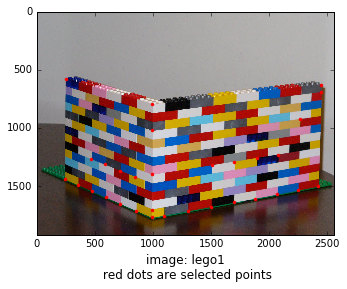

In [4]:
%matplotlib inline
img1 = np.array(Image.open("lego1.jpg"))

for i in x1_homo:
    plt.plot(int(i[0]),int(i[1]),"r.")
plt.imshow(img1)
plt.xlabel("image: lego1\n red dots are selected points",fontsize=12)


### 31 corners on the image are selected.

In [5]:
x=16.0    #compute the worldcoordinates
XX=[]
for i in range(0,8):
    XX.append(x+32*i)
    
y=32.0
Y=[]
for i in range(0,6):
    Y.append(y+32*i)
    
Z=[9.6,48.0,96.0,124.8]

RANDOM=[(80,0.,48.0),(112,0.,48.0),(144.,0.,48.0),(176.,0.,48.0),(0.,32.,38.4),(0.,64.,38.4),
        (0.,96.,38.4),(0.,128.,38.4),(240.,0.,124.8),(0.,192.,124.8),(240.,0.,115.2),(208.,0.,86.4)]
O=(0.,0.,0.)

X=[]  #world coordinates

X.append(O)
for i in XX:
    i=(i,0.,0.)
    X.append(i)

for i in Y:
    i=(0.,i,0.)
    X.append(i)

for i in Z:
    i=(0.,0.,i)
    X.append(i)

for i in RANDOM:
    i=(i[0],i[1],i[2])
    X.append(i)

X_homo=[] #homogeneous world coordinates

for i in X:
    i=[i[0],i[1],i[2],1]
    X_homo.append(i)

In [6]:
def CameraMatrix(x_homo,X_homo,img):  #input image must be grayscale
    n=len(x_homo)
    h=0
    A=np.zeros(((2*n),12),dtype="double")
    for k in range(n):
        
        A[h,:] =[0,0,0,0,-X_homo[k][0],-X_homo[k][1],-X_homo[k][2],-1,
                 x_homo[k][1]*X_homo[k][0],x_homo[k][1]*X_homo[k][1],x_homo[k][1]*X_homo[k][2],x_homo[k][1]]
        
        A[h+1,:]=[X_homo[k][0],X_homo[k][1],X_homo[k][2],1,0,0,0,0,
                  -x_homo[k][0]*X_homo[k][0],-x_homo[k][0]*X_homo[k][1],-x_homo[k][0]*X_homo[k][2],-x_homo[k][0]]
        
        h=h+2
        
    U,s,VT=np.linalg.svd(A)  #compute SVD of  matrix A 
    V=VT.T
    P=(V[:,11]).reshape(3,4)  #camera matrix
    if P[0,0]<0:
        P=-P
    p=[]
    for i in range(P.shape[1]):
        pp=P[:,i]
        pp=pp/pp[2]  #dehomogenize the coordinates
        intfy=[pp[0],pp[1],pp[2]]  #world points at infinity projected on image plane
        p.append(intfy)
 
    
    ox=np.cross(p[0],p[3])   # the result of points cross product is a line , define ox,oy,oz
    oy=np.cross(p[1],p[3])
    oz=np.cross(p[2],p[3])
    
    m,n=img.shape
    
    a=[0,0,1]  #the four corners of the image
    b=[n-1,0,1]
    c=[n-1,m-1,1]
    d=[0,m-1,1]

    ab=np.cross(a,b) # the boundary of the image
    bc=np.cross(b,c)
    cd=np.cross(c,d)
    da=np.cross(d,a)

    x_ints=np.cross(ox,bc)   # the intersection point of world axe  and image edge
    x_ints=np.int64(x_ints/x_ints[2])  #homogoneous image coordinates

    y_ints=np.cross(oy,da)
    y_ints=np.int64(y_ints/y_ints[2])

    z_ints=np.cross(oz,ab)  
    z_ints=np.int64(z_ints/z_ints[2]) 

    #print(x_ints,y_ints,z_ints)  
    return (P,p,x_ints,y_ints,z_ints)

In [7]:
img1=np.array(Image.open("lego1.jpg").convert("L"))
PP1=CameraMatrix(x1_homo,X_homo,img1)
P1=PP1[0]  #camera matrix
p1=PP1[1]  # the world axes on image plane
x_ints1=PP1[2]  #intersection points on the image edge
y_ints1=PP1[3]
z_ints1=PP1[4]
print("The camera matrix P1 of the image lego1 is :\n\n",P1)

The camera matrix P1 of the image lego1 is :

 [[  3.51869182e-03  -1.81430077e-03  -2.62634903e-05   4.86441973e-01]
 [ -1.85517941e-04  -3.34742736e-04  -3.92073778e-03   8.73694897e-01]
 [  2.40474488e-07   3.62903932e-07  -6.29229133e-08   4.92421492e-04]]


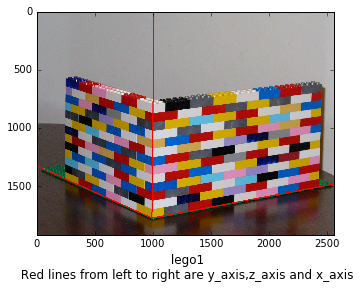

In [8]:
img1=np.array(Image.open("lego1.jpg"))
cv2.line(img1,(int(p1[3][0]),int(p1[3][1])),(x_ints1[0],x_ints1[1]),(255,0,0),8)
cv2.line(img1,(int(p1[3][0]),int(p1[3][1])),(y_ints1[0],y_ints1[1]),(255,0,0),8)
cv2.line(img1,(int(p1[3][0]),int(p1[3][1])),(z_ints1[0],z_ints1[1]),(255,0,0),8)
plt.imshow(img1)
plt.xlabel(" lego1\n Red lines from left to right are y_axis,z_axis and x_axis",fontsize=12)

### Comment: The column vectors of matrix P =[p1, p2, p3, p4], where dehomogenized p1, p2 and p3 column are points on image represent X-axis, Y-axis and Z-axis of world axes, p4 is the origin of world coordinate. By extracting p1,p2,p3,p4, we are be able to project world points at infinity onto the image plane. 

### 1(c) 
From the lecture notes on p86, the step of matrix decomposition works as follows:
1. let $W$= [0,0,1;0,1,0;1,0,0], $W^{-1} = W^T = W$.
2. QR decompose $A = (WP_{1:3})^T$, such that $A=\hat{Q}\hat{R}$.
3. $K=W\hat{R}^T W$, $R = W\hat{Q}^T $, and $C = -(P_{1:3})^{-1}p_4$

Prove K is upper-triangular, R is orthogonal, and KR[ I | -C] = P.






**1.** Since $\hat{Q}$ and $\hat{R}$ decompose matrix A, then matrix $\hat{Q}$  is orthogonal and $\hat{R}$ is up-triangular.
$$R^T R = (W\hat{Q}^T )^T W\hat{Q}^T = \hat{Q} W^T W\hat{Q}^T=\hat{Q}\hat{Q}^T=1 $$   so R is an orthogoanl matrix.

**2.** Suppose the up-triangular matrix $\hat{R} = [a,b,c;0,d,e;0,0,f] $

$$K=W\hat{R}^T W = [[0,0,1],[0,1,0],[1,0,0]]*[[a,b,c],[0,d,e],[0,0,f]]^{T} *[[0,0,1],[0,1,0],[1,0,0]]=[[f,e,c],[0,d,b],[0,0,a]]$$ 

so K is also an up-triangular matrix. 




**3.** Since $ C = - (P_{1:3})^{-1}p_4 $  , $$KR[I|-C]= W\hat{R}^T W W \hat{Q}^T [I|-C]= W\hat{R}^T  \hat{Q}^T [I|-C] = WA^T [I |-C] = P_{1:3}[I | (P_{1:3})^{-1}p_4 ] =[p_1, p_2, p_3 , p_4] =P $$

In [9]:
def decompose(P):
    w=np.zeros((3,3))
    w[0,:]=[0,0,1]
    w[1,:]=[0,1,0]
    w[2,:]=[1,0,0]
    A=(np.dot(w,P[:,:3])).T
    Qt,Rt = np.linalg.qr(A)   # QR decompose A
    K=np.dot(np.dot(w,Rt.T),w)
    R=np.dot(w,Qt.T)
    
    D=np.zeros((3,3))
    D[0,:]=[1,0,0]
    D[1,:]=[0,1,0]
    D[2,:]=[0,0,1]
    
    if K[0,0]<0:
        D[0,0]=-1
    if K[1,1]<0:
        D[1,1]=-1
    if K[2,2]<0:
        D[2,2]=-1
    K=np.dot(K,D)
    
    R=np.dot(D,R) 
    #C=-np.dot(R.T,np.dot(np.linalg.inv(K),P[:,3]))
    C=-np.dot(np.linalg.inv(np.dot(K,R)),P[:,3])  
    K[:,2]=K[:,2]/K[2,2]
    return (K,R,C)
    #print(np.dot(K,R),P[:,:3])

In [10]:
krc1=decompose(P1) #call function
K1=krc1[0]
R1=krc1[1]
C1=krc1[2]
print("The intrinsic matrix K1 is: \n\n",K1)
print("\nThe Rotation matrix R1 is: \n\n",R1)
print("\nThe camera center C1 in the world coordinate system is:\n\n " ,C1)

The intrinsic matrix K1 is: 

 [[  3.93549958e-03  -5.43579939e-06   9.78834543e+02]
 [  0.00000000e+00   3.93510720e-03   4.16630831e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

The Rotation matrix R1 is: 

 [[ 0.83417934 -0.55144077  0.00760968]
 [-0.07260464 -0.1234883  -0.98968642]
 [ 0.54669315  0.82502346 -0.14304855]]

The camera center C1 in the world coordinate system is:

  [-600.80803091 -901.85583889  328.26608923]


## Question 2 

In [11]:
img2=np.array(Image.open("lego2.jpg").convert("L"))
img2_points=[(1550.8761467889904, 1836.5642201834862),(1624.2706422018346, 1799.8669724770643),
    (1756.3807339449536, 1733.8119266055046), 
   (1881.1513761467886, 1675.0963302752293), (2002.2522935779812, 1601.7018348623856), 
   (2119.6834862385317, 1539.3165137614681), (2222.4357798165133, 1484.270642201835), 
   (2332.5275229357794, 1425.5550458715597), (2431.6100917431186, 1370.5091743119267),
 (1312.3440366972472, 1796.1972477064221), (1077.4816513761466, 1748.4908256880735), 
   (849.95871559632997, 1700.7844036697247), (626.10550458715579, 1664.0871559633028), 
   (405.92201834862362, 1616.3807339449543), (196.74770642201815, 1568.6743119266057)
,(1546.815548610336, 1759.5892956803216), (1563.9603192320569, 1422.4088067864718),
   (1569.6752427726306, 1005.2193883245898), (1563.9603192320569, 765.19259962049341),
(1888.3601036269426, 1276.5984455958551), (2006.4948186528493, 1220.6398963730571),
        (2130.8471502590673, 1158.4637305699484), (2236.5466321243521, 1121.1580310880831), 
        (1316.3393782383416, 1469.3445595854923), (1081.0596330275223, 1425.5550458715597), 
        (846.19724770642165, 1388.8577981651379), (622.34403669724747, 1344.8211009174313),
        (2464.6376146788984, 456.74770642201861), (200.41743119266039, 574.17889908256916), 
        (2460.9678899082564, 526.47247706422058), (2350.7844036697234, 787.02293577981686)]

x2_homo=homo_coord(img2_points)  #convert the input float xy coordinates to homogeneous coordinates

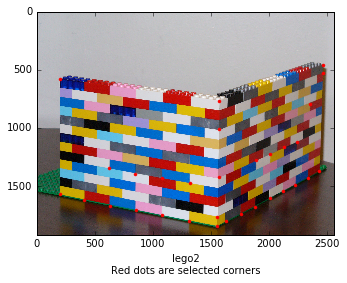

In [12]:
%matplotlib inline
img2 = np.array(Image.open("lego2.jpg"))
for i in x2_homo:
    plt.plot(i[0],i[1],"r.")
plt.imshow(img2)
plt.xlabel("lego2\nRed dots are selected corners")

In [13]:
img2=np.array(Image.open("lego2.jpg").convert("L")) #input image must be grayscale.
#img2=cv2.imread("lego2.jpg",0)
PP2=CameraMatrix(x2_homo,X_homo,img2) 
P2=PP2[0]  #camera matrix
p2=PP2[1]  #world axes on image
x_ints2=PP2[2] #intersection points
y_ints2=PP2[3]
z_ints2=PP2[4]
print("The camera matrix P of image 2 is :\n",P2)

The camera matrix P of image 2 is :
 [[  2.31013779e-03  -2.89664632e-03  -4.30783390e-06   6.44626870e-01]
 [ -3.69067606e-04  -2.91705805e-04  -3.63333803e-03   7.64479481e-01]
 [  3.21284873e-07   1.79860148e-07  -4.53693712e-08   4.15418723e-04]]


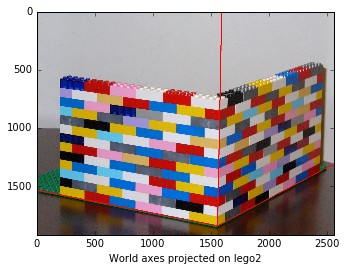

In [14]:
img2=np.array(Image.open("lego2.jpg"))
cv2.line(img2,(int(p2[3][0]),int(p2[3][1])),(x_ints2[0],x_ints2[1]),(255,0,0),6)
cv2.line(img2,(int(p2[3][0]),int(p2[3][1])),(y_ints2[0],y_ints2[1]),(255,0,0),8)
cv2.line(img2,(int(p2[3][0]),int(p2[3][1])),(z_ints2[0],z_ints2[1]),(255,0,0),8)
plt.imshow(img2)
plt.xlabel("World axes projected on lego2")

In [15]:
krc2=decompose(P2)
K2=krc2[0]
R2=krc2[1]
C2=krc2[2]
print("The intrinsic matrix K2 is: \n",K2)
print("\nThe Rotation matrix R2 is: \n",R2)
print("\nThe camera center C2 in the world coordinate system is:\n " ,C2)

The intrinsic matrix K2 is: 
 [[  3.65664948e-03   4.91244119e-06   1.60875740e+03]
 [  0.00000000e+00   3.66362787e-03  -4.50463937e+01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

The Rotation matrix R2 is: 
 [[ 0.49054301 -0.87118478  0.02011542]
 [-0.09678791 -0.07741063 -0.99229013]
 [ 0.86602521  0.48481405 -0.1222934 ]]

The camera center C2 in the world coordinate system is:
  [-945.73487754 -532.22076364  349.20270662]


In [16]:
k=200

C1X=np.dot(R1.T,[k,0,0])+C1
C1Y=np.dot(R1.T,[0,k,0])+C1
C1Z=np.dot(R1.T,[0,0,k])+C1

C2X=np.dot(R2.T,[k,0,0])+C2
C2Y=np.dot(R2.T,[0,k,0])+C2
C2Z=np.dot(R2.T,[0,0,k])+C2

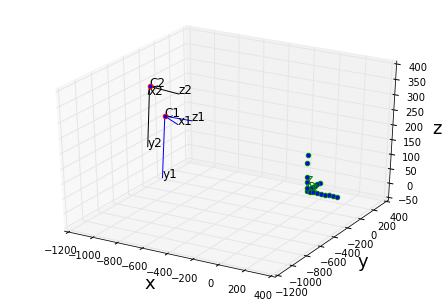

In [24]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax=Axes3D(fig)

for i in range(len(X_homo[:19])):
    ax.scatter(X[i][0],X[i][1],X[i][2],color="g")

ax.text(X[0][0],X[0][1],X[0][2],'O',fontsize=12,color="g")
ax.plot((0,k),(0,0),(0,0),color="g") #world
ax.scatter(k,0,0,color="g")
ax.text(k,0,0,'x',fontsize=12,color="g")
        
ax.plot((0,0),(0,k),(0,0),color="g") #world
ax.scatter(0,k,0,color="g")
ax.text(0,k,0,'y',fontsize=12,color="g")

ax.plot((0,0),(0,0),(0,k),color="g") #world
ax.scatter(0,0,k,color="g")
ax.text(0,0,k,'z',fontsize=12,color="g")

ax.text(C1[0],C1[1],C1[2],'C1',fontsize=12)
ax.scatter(C1[0],C1[1],C1[2],color="r") #camera 1

ax.plot((C1[0],C1X[0]),(C1[1],C1X[1]),(C1[2],C1X[2]),color="b") #camera 1
#ax.scatter(C1X[0],C1X[1],C1X[2],color="r") #camera 1
ax.text(C1X[0],C1X[1],C1X[2],'x1',fontsize=12)

ax.plot((C1[0],C1Y[0]),(C1[1],C1Y[1]),(C1[2],C1Y[2]),color="b") #camera 1
#ax.scatter(C1Y[0],C1Y[1],C1Y[2],color="r") #camera 1
ax.text(C1Y[0],C1Y[1],C1Y[2],'y1',fontsize=12)

ax.plot((C1[0],C1Z[0]),(C1[1],C1Z[1]),(C1[2],C1Z[2]),color="b") #camera 1
#ax.scatter(C1Z[0],C1Z[1],C1Z[2],color="r") #camera 1
ax.text(C1Z[0],C1Z[1],C1Z[2],'z1',fontsize=12)


ax.text(C2[0],C2[1],C2[2],'C2',fontsize=12)
ax.scatter(C2[0],C2[1],C2[2],color="r") #camera 2
ax.plot((C2[0],C2X[0]),(C2[1],C2X[1]),(C2[2],C2X[2]),color="k") #camera 2
#ax.scatter(C2[0],C2[1],C2[2],color="r") #camera 2
ax.text(C2X[0],C2X[1],C2X[2],'x2',fontsize=12)
        
ax.plot((C2[0],C2Y[0]),(C2[1],C2Y[1]),(C2[2],C2Y[2]),color="k") #camera 2
#ax.scatter(C2Y[0],C2Y[1],C2Y[2],color="k") #camera 2
ax.text(C2Y[0],C2Y[1],C2Y[2],'y2',fontsize=12)

ax.plot((C2[0],C2Z[0]),(C2[1],C2Z[1]),(C2[2],C2Z[2]),color="k") #camera 2
#ax.scatter(C2Z[0],C2Z[1],C2Z[2],color="k") #camera 2
ax.text(C2Z[0],C2Z[1],C2Z[2],'z2',fontsize=12)

plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)
ax.set_zlabel("z",fontsize=18)
plt.show()

### Comment: The orientation and location of camera 1 and camera 2 in world coordinate system are depicted above. $$R^T X_{\text{world axes}} + C =  X_{\text{camera axes}} $$  , where C is the camera center in world coordinate .

## 2(c)  

The image coordinates $x$, world coordinates $X$ and camera matrix $P$ has the following relationship:

$ x_1 = P_1 X  ,   x_2 = P_2 X   $ ,  eq(1) , it is not difficult to rewrite the above equations given new camera matix $P_1$ and $P_2$ with new world coordinates $X'$.  $ x_1 = P_1' X'   ,  x_2 = P_2' X'    $ ,    eq(2)


Since we already have $$P_1 = K_1 R_1 [ I |-C_1] , P_2 = K_2 R_2 [ I |-C_2] $$, and with $$P_1' = K_1 [I|0] , P_2' = K_2 R [ I |-C] $$,  we can substitute them into eq(1) and eq(2), the results are :
$$ x_1 = K_1 [ I|0] X' =   K_1 R_1 [ I |-C_1] X    ...................        eq(3)$$ 
$$ x_2 =   K_2 R [ I |-C] X' =  K_2 R_2 [ I |-C_2] X  ...................  eq(4)  $$  
From eq(3), we get $X_{world}' =  R_1(X_{world} - C_1) $ , feed into eq(4) , we have :

$$R=R_2 R_1^T  ,    C=R_1(C2-C1)$$
  

In [18]:
k=100
R=np.dot(R2,R1.T)
C=np.dot(R1,C2)-np.dot(R1,C1)

CX=np.dot(R.T,[k,0,0])+C
CY=np.dot(R.T,[0,k,0])+C
CZ=np.dot(R.T,[0,0,k])+C


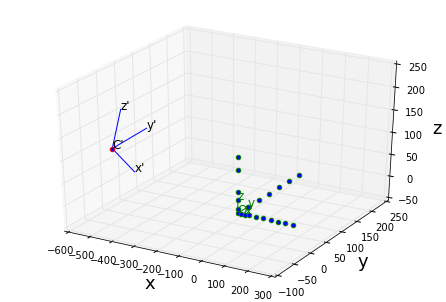

In [25]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax=Axes3D(fig)

for i in range(len(X_homo[:19])):
    ax.scatter(X[i][0],X[i][1],X[i][2],color="g")

ax.text(X[0][0],X[0][1],X[0][2],'O',fontsize=12,color="g")
ax.plot((0,k),(0,0),(0,0),color="g") #world
ax.scatter(k,0,0,color="g")
ax.text(k,0,0,'x',fontsize=12,color="g")
        
ax.plot((0,0),(0,k),(0,0),color="g") #world
ax.scatter(0,k,0,color="g")
ax.text(0,k,0,'y',fontsize=12,color="g")

ax.plot((0,0),(0,0),(0,k),color="g") #world
ax.scatter(0,0,k,color="g")
ax.text(0,0,k,'z',fontsize=12,color="g")

ax.text(C[0],C[1],C[2],'C\'',fontsize=12)
ax.scatter(C[0],C[1],C[2],color="r") #camera 2
ax.plot((C[0],CX[0]),(C[1],CX[1]),(C[2],CX[2]),color="b") #camera 2
#ax.scatter(C1X[0],C1X[1],C1X[2],color="r") #camera 2
ax.text(CX[0],CX[1],CX[2],'x\'',fontsize=12)
ax.plot((C[0],CY[0]),(C[1],CY[1]),(C[2],CY[2]),color="b") #camera 2
#ax.scatter(C1Y[0],C1Y[1],C1Y[2],color="r") #camera 2
ax.text(CY[0],CY[1],CY[2],'y\'',fontsize=12)

ax.plot((C[0],CZ[0]),(C[1],CZ[1]),(C[2],CZ[2]),color="b") #camera 2
#ax.scatter(C1Z[0],C1Z[1],C1Z[2],color="r") #camera 2
ax.text(CZ[0],CZ[1],CZ[2],'z\'',fontsize=12)

#ax.scatter(0,0,0,color="r") #camera 1
#ax.text(0,0,0,'Camera 1',fontsize=12)
#ax.scatter(C[0],C[1],C[2],color="r") #camera 2
#ax.text(C[0],C[1],C[2],'Camera 2',fontsize=12)

plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)
ax.set_zlabel("z",fontsize=18)
plt.show()

###  C' is the center of camera 2, while camera 1 axes coincidences with world coordinate axes.

### 3(a) Epipoles e and e'

In [20]:
C11=np.append(C1,[1],axis=0)
C22=np.append(C2,[1],axis=0)

e1=np.dot(P1,C22)
e1=e1/e1[2]
e2=np.dot(P2,C11)
e2=e2/e2[2]
print("The epipole e is :\n",e1)
print("\nThe epipole e' is :\n",e2)

The epipole e is :
 [ -3.77892178e+04  -2.84349893e+03   1.00000000e+00]

The epipole e' is :
 [  4.12396308e+04   1.24965508e+03   1.00000000e+00]


###  The xy image coordinates of the two epipoles are (-37789,-2843) and (41240,1250), since the image has the shape 1920*2560, so they both lie outside their visual images.

##  3(b) The fundamental matrix F

In [21]:
e2x=np.zeros((3,3))
e2x[0,1]=-e2[2]
e2x[1,0]= e2[2]

e2x[0,2]= e2[1]
e2x[2,0]=-e2[1]

e2x[1,2]=-e2[0]
e2x[2,1]= e2[0]
Psinv = np.dot(P1.T,np.linalg.inv(np.dot(P1,P1.T)))
F = np.dot(e2x,np.dot(P2,Psinv))
#Psinv=np.linalg.pinv(P1)
print("The fundemental matrix F is :\n\n ",F)

The fundemental matrix F is :

  [[  9.78789827e-02  -9.29821235e-01   1.05482451e+03]
 [ -8.69968154e-01   5.48233564e-02  -3.27195259e+04]
 [ -2.94933299e+03   3.82769742e+04  -2.61245160e+06]]


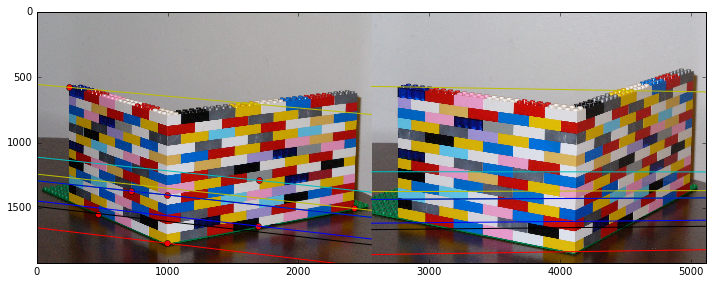

In [22]:
%matplotlib inline
img1=np.array(Image.open("lego1.jpg"))
img2=np.array(Image.open("lego2.jpg"))
m1,n1,c=img1.shape
m2,n2,c=img2.shape

match=np.zeros((m1,n1+n2,c),dtype="uint8")
match[:m1,:n1,:]=img1
match[:m1,n1:,:]=img2

plt.figure(figsize=(12,6))


a=np.arange(0,len(x1_homo),4)
b=["-r","-b","-y","-k","-g","-c","-b","-y","-k","-g","-b","-y","-k","-g"]

linex=np.arange(0,n1,1)

linex_prime=np.arange(n1,n1+n2,1)

for k,f in zip(a,b):
    ly=np.cross(x1_homo[k],e1)  #line xe epipolar line throuth x and e 
    liney=-ly[2]/ly[1]-ly[0]*linex/ly[1]
    plt.plot(x1_homo[k][0],x1_homo[k][1],"ro")

    plt.plot(linex,liney,f)
    
    l_prime=np.dot(F,x1_homo[k])
    liney_prime=-l_prime[2]/l_prime[1]-l_prime[0]*(linex_prime-n1)/l_prime[1]
    
    plt.plot(linex_prime,liney_prime,f)
    
plt.imshow(match)

### Comment:  Instead of searching correspondences  in 2D space , epipolar lines save effort  by allowing us to find matches in 1D space. The following figure shows the matched points lying on epipolar lines.

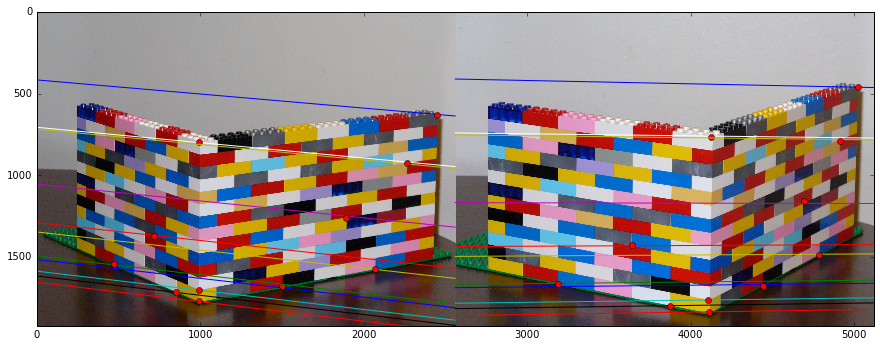

In [23]:
%matplotlib inline
from matplotlib.pyplot import cm


img1=np.array(Image.open("lego1.jpg"))
img2=np.array(Image.open("lego2.jpg"))

m1,n1,c=img1.shape
m2,n2,c=img2.shape

match=np.zeros((m1,n1+n2,c),dtype="uint8")
match[:m1,:n1,:]=img1
match[:m1,n1:,:]=img2

plt.figure(figsize=(15,8))
    
linex=np.arange(0,n1,1)
liney=[]
for x_prime in x2_homo:
    l=np.dot(F.T,x_prime)
    l=l/l[2]
    lineyy=-l[2]/l[1]-l[0]*linex/l[1]
    liney.append(lineyy)

linex_prime=np.arange(n1,n1+n2,0.1)
liney_prime=[]
for x in x1_homo:
    l_prime=np.dot(F,x)
    l_prime=l_prime/l_prime[2] 
    liney_p=-l_prime[2]/l_prime[1]-l_prime[0]*(linex_prime-n1)/l_prime[1]
    liney_prime.append(liney_p)
      

b=["-r","-b","-y","-k","-g","-c","-w","-m","-r","-b","-y","-k"]
a=np.arange(0,len(liney),3)
#color=cm.rainbow(np.linspace(0,2,2*a+2))

for k,c in zip(a,b):
    plt.plot(linex,liney[k],c)  # the color setting 
    plt.plot(x1_homo[k][0],x1_homo[k][1],"ro")
    plt.plot(linex_prime,liney_prime[k],c)
    plt.plot(x2_homo[k][0]+n1,x2_homo[k][1],"ro")
    
plt.imshow(match)